In [2]:
from scipy import stats
from scipy import integrate
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
rc('text', usetex=True)
rcParams['figure.figsize'] = (9, 5.5)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['axes.titlesize']=20.
import seaborn as sb
sb.despine()
sb.set_style('white', {'xes.linewidth': 0.5, 'axes.edgecolor':'black'})
sb.despine(left=True)

<Figure size 648x396 with 0 Axes>

### Κατανομή Poisson
Η κατανομή Poisson είναι μια διακριτή κατανομή του αριθμού γεγονότων σε ένα συγκεκριμένο χρονικό διάστημα δεδομένου του μέσου αριθμού γεγονότων $\mu$ για αυτό το διάστημα. Η συνάρτηση πυκνότητας πιθανότητας είναι:
$$
Pr(x;\mu)=\frac{\mu ^x e^{-\mu}}{x!}
$$

Η πιθανότερη τιμή της κατανομής καί η διακύμανση είναι:
\begin{align}
E[x]=\mu && var[x]=\sigma ^2=\mu
\end{align}

#### Παράδειγμα
Σε έναν αγώνα ποδοσφαίρου μπαίνουν κατα μέσο όρο $2.5$ γκόλ. Ποιά είναι η πιθανότητα να μπούν $x$ γκόλ?

No handles with labels found to put in legend.


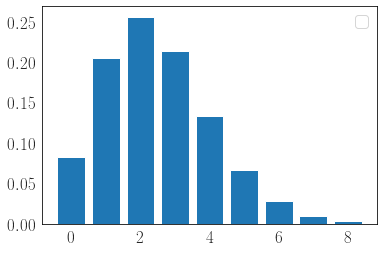

In [3]:
xx=np.linspace(0,8,9,dtype=int)
pr=stats.poisson.pmf(xx,mu=2.5)
plt.bar(xx,pr)
# for mu in np.linspace(0.5,2.5,4):
#     pr=stats.poisson(mu).pmf(xx)
#     plt.plot(xx,pr,label='$\mu = {:.2f}$'.format(mu))
plt.legend()

We will use the Poissonian Distribution to study the observed SN from earth.

From 185 until now (2019) 12 SN have been observed by eye (from wikipedia)

In [4]:
T=2019-185
N=12
r=N/T
print(f'Rate of SN per year {r:.3}')

Rate of SN per year 0.00654


Probabillity of seeing one, two (or zero) SN in one year given this rate?

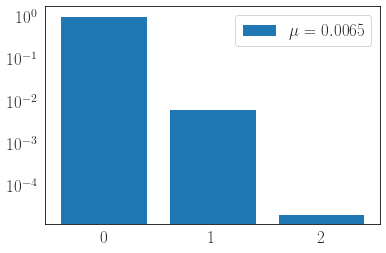

In [5]:
xx=np.arange(0,3,1,dtype=int)
pr=stats.poisson(r).pmf(xx)
plt.bar(xx,pr,label='$\mu = {:.4f}$'.format(r))
plt.yscale('log');plt.legend()

Seems that we haven't seen a SN from 1604, what is the probabillity of this happening?

Text(0.0, 0.2, 'No SN from 1604 \n unitl 2019')

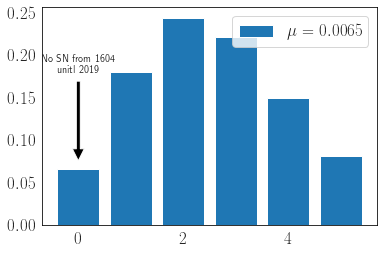

In [18]:
xx=np.arange(0,6,1,dtype=int)
pr=stats.poisson(r*(2019-1604)).pmf(xx)
plt.bar(xx,pr,label='$\mu = {:.4f}$'.format(r))
#plt.yscale('log');
plt.legend()
plt.annotate('No SN from 1604 \n unitl 2019',
            xy=(0, 0.07), xycoords='data',
            xytext=(0., 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

## Bayesian Inference

Text(0, 0.5, 'SN')

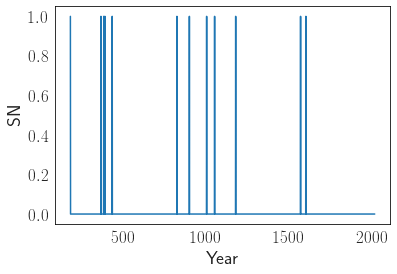

In [6]:
snt= np.array([185,369,386,393,437,827,902,1006,1054,1181,1572,1604])
tt= np.arange(185,2020,1)
sn=np.zeros(tt.shape)
for i,t in enumerate(tt):
    if t in snt:
        sn[i]=1
plt.plot(tt,sn)
plt.xlabel('Year');plt.ylabel('SN')

In [7]:
import emcee
import corner
from scipy.special import factorial

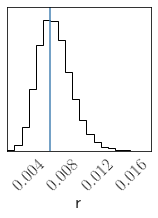

In [42]:
def norm(x,x0,s):
    return np.exp((x-x0)**2/(2*s**2))/np.sqrt(2*np.pi*s**2)
def lnlike(theta, t, N):
    r=theta
    return np.sum(np.log(r)*N-r-factorial(N))
def lnprior(theta):
    r=theta
    if 0 < r < 1:
        return 0#np.log(norm(r,1/50/2,1/50/4))
    return -np.inf
def lnprob(theta, t, N):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, N)
ndim, nwalkers = 1, 256
r0=1e-2
pos = [[np.random.uniform(1e-7,1e-2)] for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(tt, sn))
res=sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["r"],truths=[N/T])

Does something changed in the SN rate from 185 until now?

/home/astromix/anaconda3/envs/env37/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/astromix/anaconda3/envs/env37/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


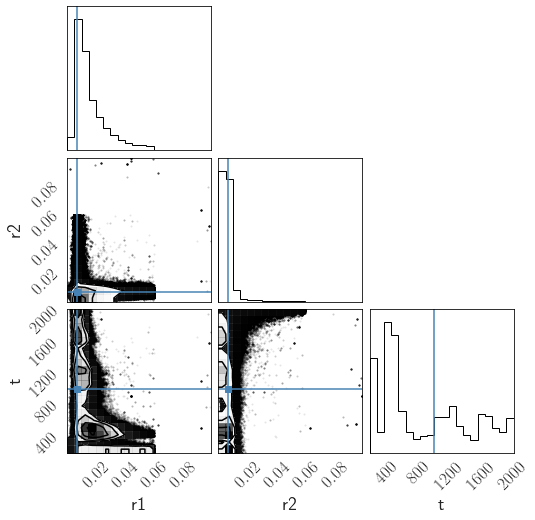

In [41]:

def lnlike(theta, t, N):
    r1,r2,tau=theta
    return np.nansum(np.where(t<tau,N*np.log(r1)-r1-factorial(N),N*np.log(r2)-r2-factorial(N)))
def lnprior(theta):
    r1,r2,tau=theta
    if (0 < r1 < 0.06) and (0 < r2 < 0.06) and (185 < tau < 2019):
        return 0#np.log(norm(r,1/50/2,1/50/4))
    return -np.inf
def lnprob(theta, t, N):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, N)
ndim, nwalkers = 3, 512
p0=[N/T,N/T,1000]
p0mi=[0,0,400]
p0ma=[0.1,0.1,2010]
pos = [np.random.uniform(p0mi,p0ma) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(tt, sn))
res=sampler.run_mcmc(pos, 5000)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["r1",'r2','t'],truths=[12/T,12/T,1000])

In [190]:
disaster_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

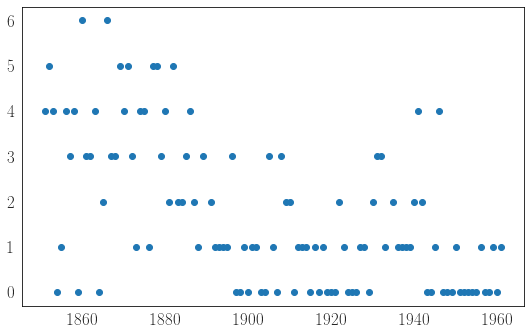

In [205]:
plt.plot(years,disaster_data,'o')

In [200]:
from scipy.special import factorial

In [202]:
factorial([1,2,3])

array([1., 2., 6.])

In [277]:
lnlike([3,2,1940],years, disaster_data)

nan

In [369]:
theta=np.random.uniform(p0mi,p0ma)
r1,r2,tau=theta
t=years
N=disaster_data
print(t[t<tau],N[t<tau]*np.log(r1)-r1-factorial(N[t<tau]))
np.nansum(np.where(t<tau,N*np.log(r1)-r1-factorial(N),N*np.log(r2)-r2-factorial(N)))

[1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864
 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878
 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892
 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906
 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920
 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934
 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953] [ -24.87547145 -120.83366656  -24.87547145   -2.04269102   -2.00088613
  -24.87547145   -6.91727634  -24.87547145   -2.04269102 -720.79186167
   -6.91727634   -6.91727634  -24.87547145   -2.04269102   -2.95908124
 -720.79186167   -6.91727634   -6.91727634 -120.83366656  -24.87547145
 -120.83366656   -6.91727634   -2.00088613  -24.87547145  -24.87547145
   -2.00088613 -120.83366656 -120.83366656   -6.91727634  -24.87547145
   -2.95908124 -120.83366656   -2.95908124   -2.95

-2737.7917198998916

In [364]:
lnlike([5.68818417e-02, 1.84081966e+00, 1.85987260e+03],years, disaster_data)

nan

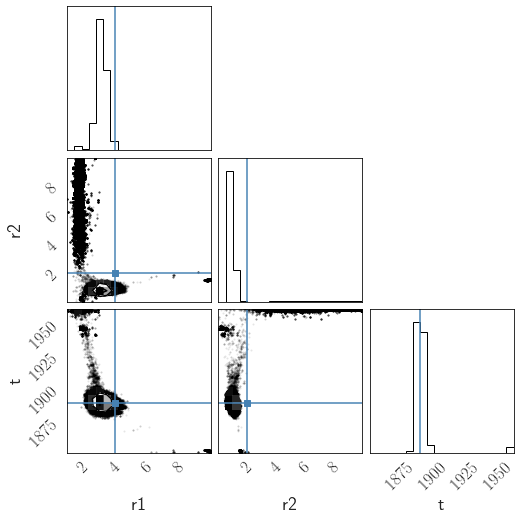

In [370]:
def lnlike(theta, t, N):
    r1,r2,tau=theta
    #return np.sum(np.where(t<tau,np.log(r1**N*np.exp(-r1)/factorial(N)),np.log(r2**N*np.exp(-r2)/factorial(N))))
    return np.nansum(np.where(t<tau,N*np.log(r1)-r1-factorial(N),N*np.log(r2)-r2-factorial(N)))
def lnprior(theta):
    r1,r2,tau=theta
    if (0 < r1 < 10) and (0 < r2 < 10) and (1851 < tau < 1962):
        return 0
    return -np.inf
def lnprob(theta, t, N):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, N)
ndim, nwalkers = 3, 1024
p0=[4,2,1890]
p0mi=[0,0,1855]
p0ma=[7,7,1960]
pos = [np.random.uniform(p0mi,p0ma) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(years, disaster_data))
sampler.run_mcmc(pos, 6000);
samples = sampler.chain[:, 50:, :].reshape((-1, ndim));

fig = corner.corner(samples, labels=["r1",'r2','t'],truths=p0)

In [371]:
pars=np.quantile(samples[100:,:],[0.5],axis=0).T

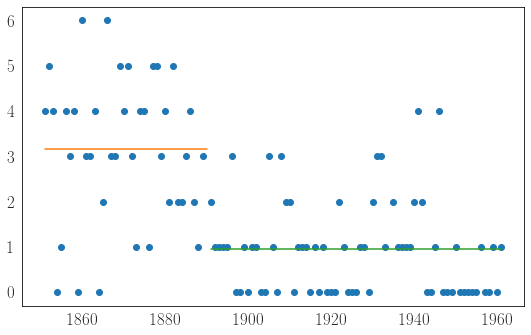

In [372]:
plt.plot(years,disaster_data,'o')
plt.plot(years[years<pars[2]],pars[0]*np.ones(years[years<pars[2]].shape[0]))
plt.plot(years[years>pars[2]],pars[1]*np.ones(years[years>pars[2]].shape[0]))

In [229]:
pars

array([[   3.95749071],
       [   2.01772077],
       [1890.01739492]])